# HAR CNN training 

In [1]:
# Imports
import numpy as np
import os
from utils.semg_utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

## Prepare data

In [2]:
X_train, labels_train, list_ch_train = read_data(data_path="/home/paperspace/sEMG-Neural-Net/sEMG/Database 2/male_day_1/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="/home/paperspace/sEMG-Neural-Net/sEMG/Database 2/male_day_1/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

In [3]:
# Normalize?
X_train, X_test = standardize(X_train, X_test)

Train/Validation Split

In [4]:
X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train, 
                                                stratify = labels_train, random_state = 123)

One-hot encoding:

In [5]:
y_tr = one_hot(lab_tr)
y_vld = one_hot(lab_vld)
y_test = one_hot(labels_test)

In [6]:
# Imports
import tensorflow as tf

### Hyperparameters

In [7]:
batch_size = 25       # Batch size
seq_len = 2500          # Number of steps
learning_rate = 0.0001
epochs = 1000

n_classes = 2
n_channels = 2

### Construct the graph
Placeholders

In [8]:
graph = tf.Graph()

# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Build Convolutional Layers

Note: Should we use a different activation? Like tf.nn.tanh?

In [9]:
with graph.as_default():
    # (batch, 2500, 2) --> (batch, 1250, 4)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=4, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    
    # (batch, 1250, 4) --> (batch, 625, 8)
    conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=8, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    
    # (batch, 32, 36) --> (batch, 16, 72)
    # conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=16, kernel_size=2, strides=1, 
    #                          padding='same', activation = tf.nn.relu)
    # max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    
    # (batch, 16, 72) --> (batch, 8, 144)
    # conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=32, kernel_size=2, strides=1, 
    #                          padding='same', activation = tf.nn.relu)
    # max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')

Now, flatten and pass to the classifier

In [10]:
with graph.as_default():
    # Flatten and add dropout
    flat = tf.reshape(max_pool_2, (-1, 8 * 625))
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    logits = tf.layers.dense(flat, n_classes)
    
    # Cost function and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

### Train the network

In [11]:
if (os.path.exists('checkpoints-cnn') == False):
    !mkdir checkpoints-cnn

In [12]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_tr, y_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : 0.5, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
            
            # Compute validation loss at every 10 iterations
            if (iteration%10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_vld, y_vld, batch_size):
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            
            # Iterate 
            iteration += 1
    
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 0.903391 Train acc: 0.600000
Epoch: 1/1000 Iteration: 10 Train loss: 0.707208 Train acc: 0.640000
Epoch: 1/1000 Iteration: 10 Validation loss: 0.817663 Validation acc: 0.400000
Epoch: 2/1000 Iteration: 15 Train loss: 0.741056 Train acc: 0.560000
Epoch: 3/1000 Iteration: 20 Train loss: 0.557548 Train acc: 0.680000
Epoch: 3/1000 Iteration: 20 Validation loss: 0.784233 Validation acc: 0.420000
Epoch: 4/1000 Iteration: 25 Train loss: 0.758597 Train acc: 0.520000
Epoch: 4/1000 Iteration: 30 Train loss: 0.793025 Train acc: 0.520000
Epoch: 4/1000 Iteration: 30 Validation loss: 0.764640 Validation acc: 0.460000
Epoch: 5/1000 Iteration: 35 Train loss: 0.651266 Train acc: 0.600000
Epoch: 6/1000 Iteration: 40 Train loss: 0.584477 Train acc: 0.680000
Epoch: 6/1000 Iteration: 40 Validation loss: 0.738268 Validation acc: 0.500000
Epoch: 7/1000 Iteration: 45 Train loss: 0.732249 Train acc: 0.520000
Epoch: 8/1000 Iteration: 50 Train loss: 0.684138 Train acc: 0.56

Epoch: 70/1000 Iteration: 425 Train loss: 0.163422 Train acc: 0.960000
Epoch: 71/1000 Iteration: 430 Train loss: 0.187042 Train acc: 0.920000
Epoch: 71/1000 Iteration: 430 Validation loss: 0.454808 Validation acc: 0.780000
Epoch: 72/1000 Iteration: 435 Train loss: 0.256536 Train acc: 0.880000
Epoch: 73/1000 Iteration: 440 Train loss: 0.153406 Train acc: 0.960000
Epoch: 73/1000 Iteration: 440 Validation loss: 0.433779 Validation acc: 0.820000
Epoch: 74/1000 Iteration: 445 Train loss: 0.223126 Train acc: 0.960000
Epoch: 74/1000 Iteration: 450 Train loss: 0.162160 Train acc: 1.000000
Epoch: 74/1000 Iteration: 450 Validation loss: 0.441477 Validation acc: 0.800000
Epoch: 75/1000 Iteration: 455 Train loss: 0.161353 Train acc: 1.000000
Epoch: 76/1000 Iteration: 460 Train loss: 0.172169 Train acc: 0.960000
Epoch: 76/1000 Iteration: 460 Validation loss: 0.429895 Validation acc: 0.800000
Epoch: 77/1000 Iteration: 465 Train loss: 0.142967 Train acc: 0.960000
Epoch: 78/1000 Iteration: 470 Train l

Epoch: 141/1000 Iteration: 850 Validation loss: 0.359890 Validation acc: 0.820000
Epoch: 142/1000 Iteration: 855 Train loss: 0.038766 Train acc: 1.000000
Epoch: 143/1000 Iteration: 860 Train loss: 0.032761 Train acc: 1.000000
Epoch: 143/1000 Iteration: 860 Validation loss: 0.323621 Validation acc: 0.840000
Epoch: 144/1000 Iteration: 865 Train loss: 0.073630 Train acc: 1.000000
Epoch: 144/1000 Iteration: 870 Train loss: 0.057867 Train acc: 1.000000
Epoch: 144/1000 Iteration: 870 Validation loss: 0.307362 Validation acc: 0.860000
Epoch: 145/1000 Iteration: 875 Train loss: 0.069547 Train acc: 1.000000
Epoch: 146/1000 Iteration: 880 Train loss: 0.042392 Train acc: 1.000000
Epoch: 146/1000 Iteration: 880 Validation loss: 0.313998 Validation acc: 0.840000
Epoch: 147/1000 Iteration: 885 Train loss: 0.103859 Train acc: 0.960000
Epoch: 148/1000 Iteration: 890 Train loss: 0.064668 Train acc: 1.000000
Epoch: 148/1000 Iteration: 890 Validation loss: 0.315461 Validation acc: 0.840000
Epoch: 149/100

Epoch: 201/1000 Iteration: 1210 Validation loss: 0.274446 Validation acc: 0.880000
Epoch: 202/1000 Iteration: 1215 Train loss: 0.047594 Train acc: 1.000000
Epoch: 203/1000 Iteration: 1220 Train loss: 0.023088 Train acc: 1.000000
Epoch: 203/1000 Iteration: 1220 Validation loss: 0.278980 Validation acc: 0.860000
Epoch: 204/1000 Iteration: 1225 Train loss: 0.064351 Train acc: 0.960000
Epoch: 204/1000 Iteration: 1230 Train loss: 0.030467 Train acc: 1.000000
Epoch: 204/1000 Iteration: 1230 Validation loss: 0.281864 Validation acc: 0.860000
Epoch: 205/1000 Iteration: 1235 Train loss: 0.046459 Train acc: 1.000000
Epoch: 206/1000 Iteration: 1240 Train loss: 0.032989 Train acc: 1.000000
Epoch: 206/1000 Iteration: 1240 Validation loss: 0.295348 Validation acc: 0.840000
Epoch: 207/1000 Iteration: 1245 Train loss: 0.035124 Train acc: 1.000000
Epoch: 208/1000 Iteration: 1250 Train loss: 0.062356 Train acc: 0.960000
Epoch: 208/1000 Iteration: 1250 Validation loss: 0.294244 Validation acc: 0.860000
E

Epoch: 264/1000 Iteration: 1590 Train loss: 0.025960 Train acc: 1.000000
Epoch: 264/1000 Iteration: 1590 Validation loss: 0.252766 Validation acc: 0.880000
Epoch: 265/1000 Iteration: 1595 Train loss: 0.011104 Train acc: 1.000000
Epoch: 266/1000 Iteration: 1600 Train loss: 0.004777 Train acc: 1.000000
Epoch: 266/1000 Iteration: 1600 Validation loss: 0.253276 Validation acc: 0.880000
Epoch: 267/1000 Iteration: 1605 Train loss: 0.026437 Train acc: 1.000000
Epoch: 268/1000 Iteration: 1610 Train loss: 0.019831 Train acc: 1.000000
Epoch: 268/1000 Iteration: 1610 Validation loss: 0.264190 Validation acc: 0.880000
Epoch: 269/1000 Iteration: 1615 Train loss: 0.016239 Train acc: 1.000000
Epoch: 269/1000 Iteration: 1620 Train loss: 0.013655 Train acc: 1.000000
Epoch: 269/1000 Iteration: 1620 Validation loss: 0.258738 Validation acc: 0.880000
Epoch: 270/1000 Iteration: 1625 Train loss: 0.009595 Train acc: 1.000000
Epoch: 271/1000 Iteration: 1630 Train loss: 0.018099 Train acc: 1.000000
Epoch: 271/

Epoch: 325/1000 Iteration: 1955 Train loss: 0.007832 Train acc: 1.000000
Epoch: 326/1000 Iteration: 1960 Train loss: 0.007539 Train acc: 1.000000
Epoch: 326/1000 Iteration: 1960 Validation loss: 0.245640 Validation acc: 0.880000
Epoch: 327/1000 Iteration: 1965 Train loss: 0.008487 Train acc: 1.000000
Epoch: 328/1000 Iteration: 1970 Train loss: 0.005832 Train acc: 1.000000
Epoch: 328/1000 Iteration: 1970 Validation loss: 0.233928 Validation acc: 0.880000
Epoch: 329/1000 Iteration: 1975 Train loss: 0.011321 Train acc: 1.000000
Epoch: 329/1000 Iteration: 1980 Train loss: 0.005233 Train acc: 1.000000
Epoch: 329/1000 Iteration: 1980 Validation loss: 0.223547 Validation acc: 0.900000
Epoch: 330/1000 Iteration: 1985 Train loss: 0.006573 Train acc: 1.000000
Epoch: 331/1000 Iteration: 1990 Train loss: 0.004452 Train acc: 1.000000
Epoch: 331/1000 Iteration: 1990 Validation loss: 0.240558 Validation acc: 0.880000
Epoch: 332/1000 Iteration: 1995 Train loss: 0.009464 Train acc: 1.000000
Epoch: 333/

Epoch: 386/1000 Iteration: 2320 Train loss: 0.007115 Train acc: 1.000000
Epoch: 386/1000 Iteration: 2320 Validation loss: 0.227177 Validation acc: 0.880000
Epoch: 387/1000 Iteration: 2325 Train loss: 0.005544 Train acc: 1.000000
Epoch: 388/1000 Iteration: 2330 Train loss: 0.007642 Train acc: 1.000000
Epoch: 388/1000 Iteration: 2330 Validation loss: 0.222618 Validation acc: 0.900000
Epoch: 389/1000 Iteration: 2335 Train loss: 0.020357 Train acc: 1.000000
Epoch: 389/1000 Iteration: 2340 Train loss: 0.007517 Train acc: 1.000000
Epoch: 389/1000 Iteration: 2340 Validation loss: 0.233478 Validation acc: 0.880000
Epoch: 390/1000 Iteration: 2345 Train loss: 0.007009 Train acc: 1.000000
Epoch: 391/1000 Iteration: 2350 Train loss: 0.005095 Train acc: 1.000000
Epoch: 391/1000 Iteration: 2350 Validation loss: 0.229411 Validation acc: 0.880000
Epoch: 392/1000 Iteration: 2355 Train loss: 0.005746 Train acc: 1.000000
Epoch: 393/1000 Iteration: 2360 Train loss: 0.003300 Train acc: 1.000000
Epoch: 393/

Epoch: 447/1000 Iteration: 2685 Train loss: 0.001817 Train acc: 1.000000
Epoch: 448/1000 Iteration: 2690 Train loss: 0.003044 Train acc: 1.000000
Epoch: 448/1000 Iteration: 2690 Validation loss: 0.204319 Validation acc: 0.900000
Epoch: 449/1000 Iteration: 2695 Train loss: 0.003365 Train acc: 1.000000
Epoch: 449/1000 Iteration: 2700 Train loss: 0.003406 Train acc: 1.000000
Epoch: 449/1000 Iteration: 2700 Validation loss: 0.206599 Validation acc: 0.900000
Epoch: 450/1000 Iteration: 2705 Train loss: 0.002404 Train acc: 1.000000
Epoch: 451/1000 Iteration: 2710 Train loss: 0.007215 Train acc: 1.000000
Epoch: 451/1000 Iteration: 2710 Validation loss: 0.205685 Validation acc: 0.900000
Epoch: 452/1000 Iteration: 2715 Train loss: 0.008861 Train acc: 1.000000
Epoch: 453/1000 Iteration: 2720 Train loss: 0.005433 Train acc: 1.000000
Epoch: 453/1000 Iteration: 2720 Validation loss: 0.204230 Validation acc: 0.900000
Epoch: 454/1000 Iteration: 2725 Train loss: 0.001369 Train acc: 1.000000
Epoch: 454/

Epoch: 510/1000 Iteration: 3065 Train loss: 0.006129 Train acc: 1.000000
Epoch: 511/1000 Iteration: 3070 Train loss: 0.002718 Train acc: 1.000000
Epoch: 511/1000 Iteration: 3070 Validation loss: 0.188776 Validation acc: 0.900000
Epoch: 512/1000 Iteration: 3075 Train loss: 0.002324 Train acc: 1.000000
Epoch: 513/1000 Iteration: 3080 Train loss: 0.005538 Train acc: 1.000000
Epoch: 513/1000 Iteration: 3080 Validation loss: 0.204388 Validation acc: 0.900000
Epoch: 514/1000 Iteration: 3085 Train loss: 0.004641 Train acc: 1.000000
Epoch: 514/1000 Iteration: 3090 Train loss: 0.003029 Train acc: 1.000000
Epoch: 514/1000 Iteration: 3090 Validation loss: 0.202558 Validation acc: 0.900000
Epoch: 515/1000 Iteration: 3095 Train loss: 0.001850 Train acc: 1.000000
Epoch: 516/1000 Iteration: 3100 Train loss: 0.001353 Train acc: 1.000000
Epoch: 516/1000 Iteration: 3100 Validation loss: 0.192588 Validation acc: 0.900000
Epoch: 517/1000 Iteration: 3105 Train loss: 0.003980 Train acc: 1.000000
Epoch: 518/

Epoch: 573/1000 Iteration: 3440 Train loss: 0.001054 Train acc: 1.000000
Epoch: 573/1000 Iteration: 3440 Validation loss: 0.181310 Validation acc: 0.920000
Epoch: 574/1000 Iteration: 3445 Train loss: 0.000799 Train acc: 1.000000
Epoch: 574/1000 Iteration: 3450 Train loss: 0.002900 Train acc: 1.000000
Epoch: 574/1000 Iteration: 3450 Validation loss: 0.161758 Validation acc: 0.920000
Epoch: 575/1000 Iteration: 3455 Train loss: 0.002463 Train acc: 1.000000
Epoch: 576/1000 Iteration: 3460 Train loss: 0.016019 Train acc: 1.000000
Epoch: 576/1000 Iteration: 3460 Validation loss: 0.174572 Validation acc: 0.920000
Epoch: 577/1000 Iteration: 3465 Train loss: 0.002728 Train acc: 1.000000
Epoch: 578/1000 Iteration: 3470 Train loss: 0.001525 Train acc: 1.000000
Epoch: 578/1000 Iteration: 3470 Validation loss: 0.167138 Validation acc: 0.920000
Epoch: 579/1000 Iteration: 3475 Train loss: 0.001199 Train acc: 1.000000
Epoch: 579/1000 Iteration: 3480 Train loss: 0.002161 Train acc: 1.000000
Epoch: 579/

Epoch: 636/1000 Iteration: 3820 Train loss: 0.000662 Train acc: 1.000000
Epoch: 636/1000 Iteration: 3820 Validation loss: 0.138339 Validation acc: 0.920000
Epoch: 637/1000 Iteration: 3825 Train loss: 0.002429 Train acc: 1.000000
Epoch: 638/1000 Iteration: 3830 Train loss: 0.001849 Train acc: 1.000000
Epoch: 638/1000 Iteration: 3830 Validation loss: 0.173218 Validation acc: 0.920000
Epoch: 639/1000 Iteration: 3835 Train loss: 0.000931 Train acc: 1.000000
Epoch: 639/1000 Iteration: 3840 Train loss: 0.001040 Train acc: 1.000000
Epoch: 639/1000 Iteration: 3840 Validation loss: 0.190067 Validation acc: 0.900000
Epoch: 640/1000 Iteration: 3845 Train loss: 0.002072 Train acc: 1.000000
Epoch: 641/1000 Iteration: 3850 Train loss: 0.001010 Train acc: 1.000000
Epoch: 641/1000 Iteration: 3850 Validation loss: 0.187852 Validation acc: 0.900000
Epoch: 642/1000 Iteration: 3855 Train loss: 0.001168 Train acc: 1.000000
Epoch: 643/1000 Iteration: 3860 Train loss: 0.001657 Train acc: 1.000000
Epoch: 643/

Epoch: 697/1000 Iteration: 4185 Train loss: 0.002674 Train acc: 1.000000
Epoch: 698/1000 Iteration: 4190 Train loss: 0.000630 Train acc: 1.000000
Epoch: 698/1000 Iteration: 4190 Validation loss: 0.157669 Validation acc: 0.920000
Epoch: 699/1000 Iteration: 4195 Train loss: 0.001148 Train acc: 1.000000
Epoch: 699/1000 Iteration: 4200 Train loss: 0.005267 Train acc: 1.000000
Epoch: 699/1000 Iteration: 4200 Validation loss: 0.147564 Validation acc: 0.920000
Epoch: 700/1000 Iteration: 4205 Train loss: 0.002496 Train acc: 1.000000
Epoch: 701/1000 Iteration: 4210 Train loss: 0.000527 Train acc: 1.000000
Epoch: 701/1000 Iteration: 4210 Validation loss: 0.146459 Validation acc: 0.920000
Epoch: 702/1000 Iteration: 4215 Train loss: 0.002951 Train acc: 1.000000
Epoch: 703/1000 Iteration: 4220 Train loss: 0.000831 Train acc: 1.000000
Epoch: 703/1000 Iteration: 4220 Validation loss: 0.142200 Validation acc: 0.920000
Epoch: 704/1000 Iteration: 4225 Train loss: 0.000872 Train acc: 1.000000
Epoch: 704/

Epoch: 759/1000 Iteration: 4560 Train loss: 0.000605 Train acc: 1.000000
Epoch: 759/1000 Iteration: 4560 Validation loss: 0.162586 Validation acc: 0.920000
Epoch: 760/1000 Iteration: 4565 Train loss: 0.001456 Train acc: 1.000000
Epoch: 761/1000 Iteration: 4570 Train loss: 0.000924 Train acc: 1.000000
Epoch: 761/1000 Iteration: 4570 Validation loss: 0.140473 Validation acc: 0.920000
Epoch: 762/1000 Iteration: 4575 Train loss: 0.000903 Train acc: 1.000000
Epoch: 763/1000 Iteration: 4580 Train loss: 0.000450 Train acc: 1.000000
Epoch: 763/1000 Iteration: 4580 Validation loss: 0.133559 Validation acc: 0.920000
Epoch: 764/1000 Iteration: 4585 Train loss: 0.000373 Train acc: 1.000000
Epoch: 764/1000 Iteration: 4590 Train loss: 0.000700 Train acc: 1.000000
Epoch: 764/1000 Iteration: 4590 Validation loss: 0.134109 Validation acc: 0.920000
Epoch: 765/1000 Iteration: 4595 Train loss: 0.000329 Train acc: 1.000000
Epoch: 766/1000 Iteration: 4600 Train loss: 0.001012 Train acc: 1.000000
Epoch: 766/

Epoch: 822/1000 Iteration: 4935 Train loss: 0.000698 Train acc: 1.000000
Epoch: 823/1000 Iteration: 4940 Train loss: 0.000842 Train acc: 1.000000
Epoch: 823/1000 Iteration: 4940 Validation loss: 0.152825 Validation acc: 0.920000
Epoch: 824/1000 Iteration: 4945 Train loss: 0.002009 Train acc: 1.000000
Epoch: 824/1000 Iteration: 4950 Train loss: 0.000435 Train acc: 1.000000
Epoch: 824/1000 Iteration: 4950 Validation loss: 0.154043 Validation acc: 0.920000
Epoch: 825/1000 Iteration: 4955 Train loss: 0.000384 Train acc: 1.000000
Epoch: 826/1000 Iteration: 4960 Train loss: 0.000454 Train acc: 1.000000
Epoch: 826/1000 Iteration: 4960 Validation loss: 0.151087 Validation acc: 0.920000
Epoch: 827/1000 Iteration: 4965 Train loss: 0.002103 Train acc: 1.000000
Epoch: 828/1000 Iteration: 4970 Train loss: 0.000678 Train acc: 1.000000
Epoch: 828/1000 Iteration: 4970 Validation loss: 0.148665 Validation acc: 0.920000
Epoch: 829/1000 Iteration: 4975 Train loss: 0.000630 Train acc: 1.000000
Epoch: 829/

Epoch: 884/1000 Iteration: 5310 Train loss: 0.000718 Train acc: 1.000000
Epoch: 884/1000 Iteration: 5310 Validation loss: 0.127501 Validation acc: 0.920000
Epoch: 885/1000 Iteration: 5315 Train loss: 0.000336 Train acc: 1.000000
Epoch: 886/1000 Iteration: 5320 Train loss: 0.000625 Train acc: 1.000000
Epoch: 886/1000 Iteration: 5320 Validation loss: 0.130776 Validation acc: 0.920000
Epoch: 887/1000 Iteration: 5325 Train loss: 0.000598 Train acc: 1.000000
Epoch: 888/1000 Iteration: 5330 Train loss: 0.001158 Train acc: 1.000000
Epoch: 888/1000 Iteration: 5330 Validation loss: 0.130999 Validation acc: 0.920000
Epoch: 889/1000 Iteration: 5335 Train loss: 0.000403 Train acc: 1.000000
Epoch: 889/1000 Iteration: 5340 Train loss: 0.000283 Train acc: 1.000000
Epoch: 889/1000 Iteration: 5340 Validation loss: 0.129298 Validation acc: 0.920000
Epoch: 890/1000 Iteration: 5345 Train loss: 0.000656 Train acc: 1.000000
Epoch: 891/1000 Iteration: 5350 Train loss: 0.000351 Train acc: 1.000000
Epoch: 891/

Epoch: 946/1000 Iteration: 5680 Train loss: 0.000112 Train acc: 1.000000
Epoch: 946/1000 Iteration: 5680 Validation loss: 0.136350 Validation acc: 0.920000
Epoch: 947/1000 Iteration: 5685 Train loss: 0.000301 Train acc: 1.000000
Epoch: 948/1000 Iteration: 5690 Train loss: 0.000462 Train acc: 1.000000
Epoch: 948/1000 Iteration: 5690 Validation loss: 0.132773 Validation acc: 0.920000
Epoch: 949/1000 Iteration: 5695 Train loss: 0.000257 Train acc: 1.000000
Epoch: 949/1000 Iteration: 5700 Train loss: 0.000576 Train acc: 1.000000
Epoch: 949/1000 Iteration: 5700 Validation loss: 0.130038 Validation acc: 0.920000
Epoch: 950/1000 Iteration: 5705 Train loss: 0.000491 Train acc: 1.000000
Epoch: 951/1000 Iteration: 5710 Train loss: 0.000124 Train acc: 1.000000
Epoch: 951/1000 Iteration: 5710 Validation loss: 0.130402 Validation acc: 0.920000
Epoch: 952/1000 Iteration: 5715 Train loss: 0.000268 Train acc: 1.000000
Epoch: 953/1000 Iteration: 5720 Train loss: 0.000512 Train acc: 1.000000
Epoch: 953/

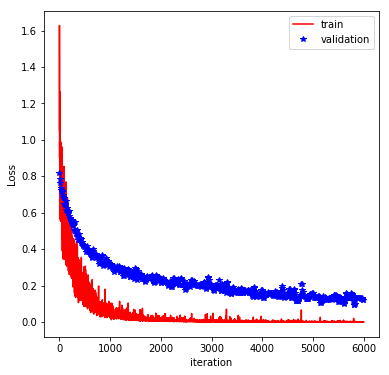

In [13]:
# Plot training and test loss
t = np.arange(iteration-1)

plt.figure(figsize = (6,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

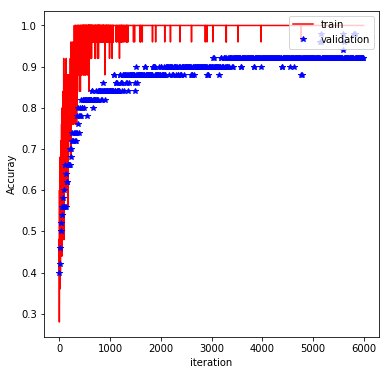

In [14]:
# Plot Accuracies
plt.figure(figsize = (6,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [15]:
test_acc = []

with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_test, batch_size):
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
        
        batch_acc = sess.run(accuracy, feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test accuracy: 0.980000
